In [66]:
# Plan: Create a trading bot
# TO DO:
# Agent: the learner or interactor(the sentient)
# Environment: the world the agent lives and interacts in
# Policy: the rules the agent follows in response to changes in the Environment
# Observation: changes in the environment of which are sent to the Agent
# Action: reactions to observations made by the agent of which are sent to the Environment

# Add a method to buy and sell certain amounts not all or nothing
# Create different dataframes in bear or bull markets and differnte intervals(1hr, 1dy, etc) and lengths(1yr, 10yrs, etc)
# create render method
# create a random agent 
# create AI agent

In [7]:
filepath = 'data\BTC-USD_hourly2020.csv'
data = pd.read_csv(filepath)


In [70]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-23 00:00,7138.29,7158.70,7108.00,7122.21,81.59
1,2020-04-23 01:00,7126.30,7192.82,7118.33,7186.36,175.45
2,2020-04-23 02:00,7186.72,7193.13,7129.19,7130.00,131.63
3,2020-04-23 03:00,7130.92,7163.41,7117.97,7118.83,227.12
4,2020-04-23 04:00,7115.90,7137.92,7102.62,7132.38,60.48


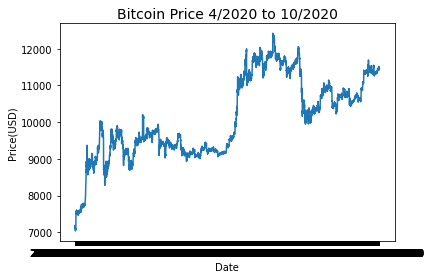

In [71]:
plt.plot(data['Date'], data['Open'])
plt.title('Bitcoin Price 4/2020 to 10/2020', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price(USD)', fontsize=10)
plt.show()

In [4]:
import gym
import pandas as pd
import numpy as np
from gym import spaces
from sklearn import preprocessing
import matplotlib.pyplot as plt
from utils import TradingGraph

import warnings
warnings.filterwarnings('ignore')


In [5]:
MAX_TRADING_SESSION = 4301


class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'bot', 'none']}
    scaler = preprocessing.MinMaxScaler()
    viewer = None

    def __init__(self, df, lookback_window_size=50, commission=0.00075, initial_balance=10000, serial=False):
        super(TradingEnv, self).__init__()
        self.df = df.dropna().reset_index()
        self.lookback_window_size = lookback_window_size
        self.initial_balance = initial_balance
        self.commission = commission
        self.serial = serial

        # actions space 0: buy 100%, 1: hold, 2, sell 100%
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(
            10, lookback_window_size + 1), dtype=np.float16)

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.asset_held = 0

        self._reset_session()

        self.account_history = np.repeat([
            [self.net_worth],
            [0],
            [0],
            [0],
            [0]],
             self.lookback_window_size + 1, axis=1)

        self.trades = []

        return self._next_observation()

    def step(self, action):
        prev_net_worth = self.net_worth
        current_price = self._get_current_price() + 0.01
        self._take_action(action, current_price)
        self.steps_left -= 1
        self.current_step += 1

        if self.steps_left == 0:
            self.balance += self.asset_held * current_price
            self.asset_held = 0
            self._reset_session()
        
        obs = self._next_observation()
        reward = self.net_worth - prev_net_worth
        done = self.net_worth <= 0

        return obs, reward, done, {}

    def render(self, mode='human'):
        if mode == 'human':
            if self.viewer is None:
                self.viewer = TradingGraph(self.df)
            self.viewer.render(self.current_step, self.net_worth, self.trades)
        elif mode == 'bot':
            print('Current Step: ' + str(self.current_step))
            print('Net Worth: ' + str(self.net_worth) + ' USD')
            print('Cash Balance: ' + str(self.balance) + ' USD')
            print('Asset Balance: ' + str(self.asset_held))

    def _reset_session(self):
        self.current_step = 0

        if self.serial:
            self.steps_left = len(self.df) - self.lookback_window_size - 1
            self.frame_start = self.lookback_window_size
        else:
            self.steps_left = np.random.randint(1, MAX_TRADING_SESSION)
            self.frame_start = np.random.randint(
                self.lookback_window_size, len(self.df) - self.steps_left)

        self.active_df = self.df[self.frame_start -
                                 self.lookback_window_size:self.frame_start + self.steps_left]

    def _next_observation(self):
        end = self.current_step + self.lookback_window_size + 1

        obs = np.array([
            self.active_df['Open'].values[self.current_step:end],
            self.active_df['High'].values[self.current_step:end],
            self.active_df['Low'].values[self.current_step:end],
            self.active_df['Close'].values[self.current_step:end],
            self.active_df['Volume'].values[self.current_step:end],
        ])

        scaled_history = self.scaler.fit_transform(self.account_history)

        obs = np.append(obs, scaled_history[:, -(self.lookback_window_size + 1):], axis= 0)
    
        return obs

    def _take_action(self, action, current_price):
        action_type = action

        asset_bought = 0
        asset_sold = 0
        cost = 0
        sales = 0

        if action < 1: 
            cost = self.balance
            asset_bought = (self.balance / current_price  * ( 1 - self.commission)) 
            self.asset_held += asset_bought
            self.balance = 0
        elif action > 1:
            sale = self.asset_held * current_price * (1 - self.commission)
            asset_sold = self.asset_held
            self.asset_held = 0
            self.balance += sales

        if asset_sold > 0 or asset_bought > 0:
            self.trades.append({
                'step': self.frame_start+self.current_step,
                'amount': asset_sold if asset_sold > 0 else asset_bought,
                'total': sales if asset_sold > 0 else cost,
                'type': "sell" if asset_sold > 0 else "buy"
            })
        
        self.net_worth = self.balance + self.asset_held * current_price
        self.account_history = np.append(self.account_history, [[self.net_worth], [asset_bought], [cost], [asset_sold], [sales]], axis=1)

    def _get_current_price(self):
        index = self.current_step
        low = self.df.loc[index,'Low']
        high = self.df.loc[index, 'High']
        return (low + high) / 2

In [8]:
env = TradingEnv(data, serial=True)
env.reset()
env.net_worth

10000

In [10]:
env.render()

AttributeError: 'TradingGraph' object has no attribute 'render'